In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")
 
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10


In [4]:
batch_size = 32 
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch
 
num_classes = 10 #
epochs = 100 # repeat 100 times

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

170500096/170498071 [==============================] - 71s 0us/step


In [5]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

In [6]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [11]:
def base_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = base_model()
#model.summary()
 

In [16]:
x_train.shape

(50000, 3, 32, 32)

In [18]:

model.fit(x_train[:50000], y_train[:50000], validation_data=(x_test[:1000], y_test[:1000]), epochs=15, batch_size=200, verbose=2)
# Final evaluation of he model
#scores = model.evaluate(x_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 50000 samples, validate on 1000 samples
Epoch 1/15
 - 287s - loss: 1.0473 - acc: 0.6306 - val_loss: 0.9270 - val_acc: 0.6590
Epoch 2/15
 - 287s - loss: 0.9383 - acc: 0.6705 - val_loss: 0.8210 - val_acc: 0.7220
Epoch 3/15
 - 283s - loss: 0.8678 - acc: 0.6941 - val_loss: 0.7634 - val_acc: 0.7280
Epoch 4/15
 - 283s - loss: 0.8093 - acc: 0.7158 - val_loss: 0.7306 - val_acc: 0.7480
Epoch 5/15
 - 283s - loss: 0.7533 - acc: 0.7343 - val_loss: 0.6838 - val_acc: 0.7600
Epoch 6/15
 - 285s - loss: 0.7137 - acc: 0.7497 - val_loss: 0.6853 - val_acc: 0.7710
Epoch 7/15
 - 285s - loss: 0.6790 - acc: 0.7611 - val_loss: 0.6638 - val_acc: 0.7770
Epoch 8/15
 - 285s - loss: 0.6490 - acc: 0.7704 - val_loss: 0.6826 - val_acc: 0.7670
Epoch 9/15
 - 285s - loss: 0.6263 - acc: 0.7800 - val_loss: 0.6312 - val_acc: 0.7910
Epoch 10/15
 - 286s - loss: 0.5914 - acc: 0.7913 - val_loss: 0.6387 - val_acc: 0.7840
Epoch 11/15
 - 287s - loss: 0.5698 - acc: 0.7988 - val_loss: 0.6093 - val_acc: 0.7900
Epoch 12/15
 -

In [88]:
model.layers[-1].output

<tf.Tensor 'dense_8/Softmax:0' shape=(?, 10) dtype=float32>

In [19]:
import keras.backend as K
f = K.function([model.layers[0].input, K.learning_phase()],
               [model.layers[-1].output])

In [26]:
img = x_test[:2]
img = np.random.rand(2,3,32,32)

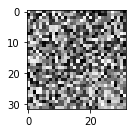

In [27]:
plt.subplot(221)
plt.imshow(img[0,0,:,:], cmap=plt.get_cmap('gray'))
plt.show()

In [28]:
f((img,1))

[array([[  2.94115423e-04,   6.42496816e-05,   5.21184921e-01,
           2.10020994e-03,   1.60975324e-04,   2.38419034e-07,
           4.74765390e-01,   2.10050800e-07,   1.19488162e-03,
           2.34702457e-04],
        [  1.09571312e-03,   1.13610958e-03,   4.39215973e-02,
           7.92512763e-03,   7.21118087e-03,   5.19666116e-07,
           5.75624168e-01,   2.56241890e-07,   5.03218174e-02,
           3.12763542e-01]], dtype=float32)]

In [68]:
f((img,1))[0].shape

(2, 10)

In [32]:
def predict_with_uncertainty(f, x, n_iter=10):
    results = []

    for iter in range(n_iter):
        results.append(f((x,1)))
    results = np.array(results)

    prediction = results.mean(axis=0)
    prediction = np.squeeze(prediction,axis=0)
    uncertainty = results.var(axis=0)
    uncertainty = np.squeeze(uncertainty,axis=0)
    return prediction, uncertainty

In [52]:
def test_var(img):
    pred,var = predict_with_uncertainty(f,img)
    labels = pred.argmax(axis=1)
    print(pred.max(axis=1))
    print(var[[0,1],labels])

In [53]:
img = x_test[9:11]
test_var(img)

[ 0.60445803  0.81418914]
[ 0.06640231  0.04342259]


In [61]:
img = np.random.rand(2,3,32,32)
test_var(img)

[ 0.7280162   0.76298922]
[ 0.0807835   0.09471871]
